Comp 47350 - Assignment 2  
Tania Lopes  
*22202398*

# **1.0 Introduction**
<span style="color: red; font-style: italic">Refer to '22202398_Data Quality Report' for a brief introduction to the machine learning problem we would like to solve in addition to some key terminology to be familiar with. </span>

This notebook will be split into 5 main parts.   
- [1.0 Introduction](#10-introduction)
- [2.0 Data Understanding and Preparation](#20-data-understanding-and-preparation)
- [3.0 Predictive Modeling - Linear Regression](#30-predictive-modeling-linear-regression)
- [4.0 Predictive Modeling - Logical Regression](#40-predictive-modeling-logistic-regression)
- [5.0 Predictive Modeling - Random Forest](#50-predictive-modeling-random-forest)



# **2.0 Data Understanding and Preparation** 

## 2.1 Prepare environment and load data
First things first, we need to import the packages that will help us with our data analysis.

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap

from sklearn.impute import KNNImputer

### Define Some Functions that will help us throughout to analyze the data and regressions

In [98]:
def calculateNthMode(dataFrame, n):
    describeData = dataFrame.describe(datetime_is_numeric = True).T

    indices = describeData.index.values.tolist()

    secondMode = []
    secondModeFreq = []
    
    for column in dataFrame:
        secondMode.append(dataFrame[column].value_counts().index.tolist()[n-1])
        secondModeFreq.append(dataFrame[column].value_counts().tolist()[n-1])

    second_mode = pd.DataFrame(secondMode, columns=[f'{n}th mode']).set_index([indices]).T
    second_mode_freq = pd.DataFrame(secondModeFreq, columns=[f'{n}th mode freq']).set_index([indices]).T

    return second_mode, second_mode_freq


def applyToRowsAndAppend(dataFrame, expression, columnName):
    tempDataFrame_result = dataFrame.apply(expression, axis=1).rename(columnName)
    tempDataFrame = pd.concat([dataFrame, tempDataFrame_result], axis=1)
    return tempDataFrame


def getDescriptiveStatisticsForContinuousFeatures(dataFrame):
    # Get descriptive statistics, mode, second mode, and cardinality
    stats = dataFrame.describe(datetime_is_numeric = True)

    n_missing = pd.DataFrame((dataFrame.isnull()).sum(), columns=['# missing']).T
    p_missing = pd.DataFrame(((dataFrame.isnull()).sum() / dataFrame.shape[0] * 100), columns=['% missing']).T

    first_mode, first_modeFreq = calculateNthMode(dataFrame, 1)
    second_mode, second_modeFreq = calculateNthMode(dataFrame, 2)
    cardinality = pd.DataFrame(dataFrame.nunique(), columns=['cardinality']).T

    # Concatenate statistics into one descriptive statistics table
    stats = pd.concat([stats, n_missing, p_missing, first_mode, first_modeFreq, second_mode, second_modeFreq, cardinality]).T

    return stats


def getDescriptiveStatisticsForCategoricalFeatures(dataFrame):
    # Calculate the number of missing entries for each of the continuous feature
    stats = dataFrame.describe()

    n_missing = pd.DataFrame((dataFrame == 'Missing').sum(), columns=['# missing']).T
    p_missing = pd.DataFrame(((dataFrame == 'Missing').sum() / dataFrame.shape[0] * 100), columns=['% missing']).T

    # Calculate second mode
    second_mode, second_mode_frequency = calculateNthMode(dataFrame, 2)

    # Concatenate statistics into one descriptive statistics table
    stats = pd.concat([stats, n_missing, p_missing, second_mode, second_mode_frequency]).T

    return stats


def getValidityColumn(dataFrame, expression):
    validity_result = applyToRowsAndAppend(dataFrame, expression, 'Validity')
    
    # Count the number of columns where validity is not equal to True
    invalid_entry = validity_result['Validity'].value_counts().index.tolist()

    if len(invalid_entry) == 1 and invalid_entry[0]:
        print("The data passes the test.")
    else:
        count_invalid_entry = len(validity_result.loc[validity_result['Validity'] == False])
        print(f"The data does not pass the test. \n{count_invalid_entry} invalid entries.")

def get_correlations(data, columns, abs_corr=False):
    correlation = data[columns].corr(numeric_only=False)
    if (abs_corr):
        correlation = abs(correlation)
    return correlation

def plot_correlation_heatmap(data, columns, ax=None, abs_corr=False):
    # Print the correlation between the continuous data types
    # Specify numeric_only as False to allow us to include correlation with case_month
    correlation = get_correlations(data, columns, abs_corr)

    # Generate a mask for the upper triangle
    corr_mask = np.zeros_like(correlation, dtype=np.bool_)
    corr_mask[np.triu_indices_from(corr_mask)] = True

    # Generate a custom colormap - blue and red
    corr_cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Use the provided ax or create a new one
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(correlation, annot=True, mask=corr_mask, cmap=corr_cmap, vmax=1, vmin=-1,
                square=True, xticklabels=True, yticklabels=True,
                linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
    
    # Set the title of the plot
    ax.set_title('Correlation Heatmap')
    
    # Show the plot if no ax was provided
    if ax is None:
        plt.show()


def createStackedHistograms(data, group, to_count, bin_count=10, ax=None, i=None, j=None, filterExp=None, labelheights=None, ylim = 1):
    
    # group the data by the specified column
    data = data.dropna().copy()
    if filterExp != None:
        data = data.loc[data.apply(filterExp, axis=1)]
    if data[to_count].dtype == 'datetime64[ns]':
        data.loc[:, to_count] = (data[to_count].apply(lambda x: (x.year - data[to_count].min().year) * 12 + x.month))
    
    grouped_data = data.groupby(group)[to_count]

    values = data[to_count]
    bin_range = np.linspace(values.min(), values.max(), bin_count + 1)
    bin_width = bin_range[1]-bin_range[0]

    # Create a list of zeros to be the bottom value of each histogram bar
    bottom = 0
    bottom_value = [bottom for i in range(bin_count)]
    # Create a list of ones to be the bottom value of each histogram bar
    top = ylim
    top_value = [top for i in range(bin_count)]
    # Create a list of zeros to be a placeholder for number of bars too small to show text
    too_small_count = [0 for i in range(bin_count)]

    for name, group_data in grouped_data:
        # Get counts for histogram
        hist, _ = np.histogram(group_data, bins=bin_range)
        pct = hist / len(group_data) if len(group_data) != 0 else 0

        # Draw the histogram for the first group
        ax.bar(bin_range[:-1], pct, label=name, align='edge', width=bin_width,
               bottom=bottom_value, edgecolor='black', linewidth=0.5)
        ax.set_ylim(top=1)
        if labelheights == None:
            labelheights = (len(grouped_data) * 0.025,
                            len(grouped_data) * 0.025)

        # Count the values that will be too small to display in the center of the bar
        threshold = labelheights[0]
        if not isinstance(pct, np.ndarray):
            increment = 1 if 0 < pct < threshold else 0
            too_small_count = [tsc + increment for tsc in too_small_count]
            bottom_value = [bv + pct for bv in bottom_value]
        else:
            increment = list(map(lambda h: 1 if 0 < h < threshold else 0, pct))
            too_small_count = [tsc + i for tsc, i in zip(too_small_count, increment)]
            bottom_value += pct

        def createlabel(val):
            x = bin_range[i]+bin_width/2
            y = bottom_value[i]-val/2 + (too_small_count[i])*labelheights[1]
            text_name = textwrap.shorten(str(name).replace("/", " / ").replace("-"," - "), width=13, placeholder="...")
            val_text = int(round(val, 2)*100)
            ax.text(
                x=x, y=y, fontsize=6,
                s=f"{text_name}:\n {val_text}%",
                ha='center', va='center', zorder=4
            )

            rect = plt.Rectangle((x-bin_width*.9/2, y-(labelheights[1]*.8)/2),
                             width=bin_width*0.9, height=labelheights[1]*.8,
                             zorder=3, alpha=0.5, facecolor="white",
                             linewidth=0.5, edgecolor='black')
            ax.add_patch(rect)


        # Create text labels for each bar
        if not isinstance(pct, np.ndarray):
            val = pct
            if val != 0:
                createlabel(val)

        else:
            for i, val in enumerate(pct):
                if val != 0:
                    createlabel(val)
        
        ax.set_xticks(bin_range)
        ax.grid(axis='y', alpha=0.5, color='lightgrey', linestyle='--')
        ax.set_yticks(np.linspace(bottom, top, 11))


        # Axis labels
        ax.set_xlabel(str(to_count).title().replace("_", " "), labelpad=20)
        ax.set_ylabel(f'Frequency of {group.replace("_", " ").title()}', labelpad=20)

        title = f'{to_count} by {group}'.replace("_", " ").title()
        ax.set_title(title, fontsize=18, pad=20)
        ax.legend()


### Merging the datasets
<span style="color: red; font-style: italic"> write about the work done in the previous assignment to prepare a clean data set, as well as steps taken to merge the two datasets. </span>  
The data from the previous assignment is imported below, with two files, one for each student. We use pandas to concatenate the two sets into one large dat set.

In [99]:
data_student_01 = pd.read_csv('data\covid19-cdc-22202398_final.csv', keep_default_na=True)
data_student_02 = pd.read_csv('data\covid19-cdc-18389156_final.csv', keep_default_na=True)

data = pd.concat([data_student_01, data_student_02], axis=0)

data.head(10)

,case_month,county_fips_code,age_group,sex,race,ethnicity,case_positive_specimen_interval,case_onset_interval,current_status,symptom_status,hosp_yn,death_yn,income,people_vaccinated,risk_factor
0,2020-11-01,32003,65+ years,Female,White,Non-Hispanic/Latino,2.0,0.0,Laboratory-confirmed case,Symptomatic,Yes,Yes,59340,0,1
1,2021-08-01,4013,50 to 64 years,Male,White,Hispanic/Latino,3.0,0.0,Laboratory-confirmed case,Symptomatic,No,Yes,64468,206797098,1
2,2020-12-01,12101,65+ years,Male,White,Non-Hispanic/Latino,0.0,0.0,Laboratory-confirmed case,Symptomatic,Yes,Yes,52828,5566951,1
3,2020-12-01,6037,65+ years,Female,White,Non-Hispanic/Latino,2.0,0.0,Laboratory-confirmed case,Symptomatic,Yes,Yes,68044,5566951,1
4,2020-11-01,48029,65+ years,Male,White,Hispanic/Latino,0.0,6.0,Laboratory-confirmed case,Symptomatic,Yes,Yes,57157,0,1
5,2020-08-01,1097,65+ years,Female,White,Non-Hispanic/Latino,0.0,0.0,Laboratory-confirmed case,Symptomatic,Yes,Yes,47583,0,1
6,2021-09-01,16027,65+ years,Male,White,Non-Hispanic/Latino,0.0,0.0,Laboratory-confirmed case,Symptomatic,Yes,Yes,52134,215360247,1
7,2021-11-01,39133,65+ years,Female,White,Non-Hispanic/Latino,1.0,0.0,Laboratory-confirmed case,Symptomatic,Yes,Yes,57618,233824494,1
8,2020-12-01,49035,65+ years,Male,White,Non-Hispanic/Latino,0.0,0.0,Laboratory-confirmed case,Symptomatic,No,Yes,74865,5566951,1
9,2021-01-01,12086,65+ years,Female,White,Hispanic/Latino,0.0,0.0,Laboratory-confirmed case,Symptomatic,Yes,Yes,51347,29890726,1


To recap what has already been done, we will check the shape of the set, inspect the datatypes and check if there are any remaining invalid null values.

In [100]:
rows, columns = data.shape
print(f"The data set has {rows} rows and {columns} columns.")

The data set has 37940 rows and 15 columns.


### Assigning DataTypes

In [101]:
data.dtypes

case_month                          object
county_fips_code                     int64
age_group                           object
sex                                 object
race                                object
ethnicity                           object
case_positive_specimen_interval    float64
case_onset_interval                float64
current_status                      object
symptom_status                      object
hosp_yn                             object
death_yn                            object
income                               int64
people_vaccinated                    int64
risk_factor                          int64
dtype: object

The data types we have assigned in the data cleaning step were not preserved when the file was converted to a .csv. As such, we will need to reintroduce them before starting to work with the data. First we will assign ints and datetime types to the relevant features.

In [103]:
# Get continuous date features and int features separately
continuous_date = ['case_month']
continuous_int = ['case_positive_specimen_interval', 'case_onset_interval', 'income', 'people_vaccinated']

# Get aggregated continuous features
continuous = continuous_date + continuous_int

# Assign types to columns - dates
for column in continuous_date:
    data[column] = data[column].astype('datetime64[ns]')

# Assign types to columns - integers
for column in continuous_int:
    data[column] = data[column].astype('Int64')

# Print data types
data.dtypes

case_month                         datetime64[ns]
county_fips_code                            int64
age_group                                  object
sex                                        object
race                                       object
ethnicity                                  object
case_positive_specimen_interval             Int64
case_onset_interval                         Int64
current_status                             object
symptom_status                             object
hosp_yn                                    object
death_yn                                   object
income                                      Int64
people_vaccinated                           Int64
risk_factor                                 int64
dtype: object

Next, we will assign data types to the categorical features. We will separate these features into two categories: boolean and category.  
$~$  
**Boolean Features**
- current_status: True for Laboratory Confirmed Case, False for Probably Case
- symptom_status: True for Symptomatic, False for Asymptomatic
- hosp_yn: 
- risk_factor: True for 1, False for 0
- detah_yn: True for y, False for n  

**Category Features**  
- county_fips_code (*this feature is perhaps too granular, so we will replace it with state fips code*)
- age_group
- sex
- race
- ethnicity

In [104]:
# Get categorical features
categorical_category = ['county_fips_code', 'age_group', 'sex', 'race', 'ethnicity']
categorical_bool = ['current_status', 'symptom_status', 'hosp_yn', 'risk_factor', 'death_yn']
categorical =  categorical_category + categorical_bool

# Assign types to columns - boolean
for column in categorical_bool:
    if column == 'current_status':
        data[column] = data[column].map({'Laboratory-confirmed case': 1, 'Probable Case': 0})
    elif column == 'symptom_status':
        data[column] = data[column].map({'Symptomatic': 1, 'Asymptomatic': 0})
    elif column == 'risk_factor':
        data[column] = data[column].astype(bool)
    elif column == 'hosp_yn' or column == 'death_yn':
        data[column] = data[column].map({'Yes': 1, 'No': 0})
    elif column == 'risk_factor':
        data[column] = data[column].map({1: 1, 0: 0})
    data[column] = data[column].astype('Int64')

# Assign types to columns - categorical
for column in categorical_category:
    data[column] = data[column].astype('category')

# Rename columns to match restructuring of data
data.rename(columns={'current_status': 'laboratory_confirmed_tf', 'symptom_status': 'symptomatic_tf', 'hosp_yn': 'hosp_tf', 'risk_factor': 'risk_factor_tf', 'death_yn': 'death_tf'}, inplace=True)

data.dtypes

case_month                         datetime64[ns]
county_fips_code                         category
age_group                                category
sex                                      category
race                                     category
ethnicity                                category
case_positive_specimen_interval             Int64
case_onset_interval                         Int64
laboratory_confirmed_tf                     Int64
symptomatic_tf                              Int64
hosp_tf                                     Int64
death_tf                                    Int64
income                                      Int64
people_vaccinated                           Int64
risk_factor_tf                              Int64
dtype: object

In [105]:
# Update county_fips_code column, converting county fips codes to state fips codes
data['county_fips_code'] = data['county_fips_code'].apply(lambda row: row // 1000)
data.rename(columns={'county_fips_code': 'state_fips_code'}, inplace=True)

# Get renamed categorical features
categorical_category = ['state_fips_code', 'age_group', 'sex', 'race', 'ethnicity']
categorical_bool = ['laboratory_confirmed_tf', 'symptomatic_tf', 'hosp_tf', 'risk_factor_tf', 'death_tf']
categorical =  categorical_category + categorical_bool

In [106]:
data.head(100)

,case_month,state_fips_code,age_group,sex,race,ethnicity,case_positive_specimen_interval,case_onset_interval,laboratory_confirmed_tf,symptomatic_tf,hosp_tf,death_tf,income,people_vaccinated,risk_factor_tf
0,2020-11-01,32,65+ years,Female,White,Non-Hispanic/Latino,2,0,1,1,1,1,59340,0,1
1,2021-08-01,4,50 to 64 years,Male,White,Hispanic/Latino,3,0,1,1,0,1,64468,206797098,1
2,2020-12-01,12,65+ years,Male,White,Non-Hispanic/Latino,0,0,1,1,1,1,52828,5566951,1
3,2020-12-01,6,65+ years,Female,White,Non-Hispanic/Latino,2,0,1,1,1,1,68044,5566951,1
4,2020-11-01,48,65+ years,Male,White,Hispanic/Latino,0,6,1,1,1,1,57157,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2020-04-01,36,65+ years,Female,White,Hispanic/Latino,0,0,1,1,1,1,40088,0,1
96,2020-06-01,6,50 to 64 years,Female,White,Hispanic/Latino,2,0,1,1,1,1,68044,0,1
97,2020-04-01,36,65+ years,Male,White,Non-Hispanic/Latino,0,0,1,1,1,1,60231,0,1
98,2021-12-01,72,65+ years,Male,Multiple/Other,Hispanic/Latino,0,0,1,1,1,1,51347,244166911,1


In [107]:
data.dtypes

case_month                         datetime64[ns]
state_fips_code                             int64
age_group                                category
sex                                      category
race                                     category
ethnicity                                category
case_positive_specimen_interval             Int64
case_onset_interval                         Int64
laboratory_confirmed_tf                     Int64
symptomatic_tf                              Int64
hosp_tf                                     Int64
death_tf                                    Int64
income                                      Int64
people_vaccinated                           Int64
risk_factor_tf                              Int64
dtype: object

### Checking Null Values

In [108]:
data.isna().sum()

case_month                            0
state_fips_code                       0
age_group                             0
sex                                   0
race                                  0
ethnicity                             0
case_positive_specimen_interval    2490
case_onset_interval                 550
laboratory_confirmed_tf               0
symptomatic_tf                        0
hosp_tf                               0
death_tf                              0
income                                0
people_vaccinated                     0
risk_factor_tf                        0
dtype: int64

As expected, the 'case_positive_specimen_interval' and 'case_onset_interval' features contain null values, which are logical considering the nature of the data. To incorporate these features in the regression models, we have several options for handling the null values.

We can immediately eliminate the option of dropping the features due to the small percentage of null values. To address the null values in each column, we will instead consider two approaches: imputation with representative values and replacement with a distinct value. 
1. **Imputation**: We will explore three strategies - imputing with the median, mean, and mode values of the non-null data.
2. **Replacement**: We will also consider replacing the null values with a distinct value that significantly exceeds the range of actual values, such as -1 or 999.
To determine the best approach, we will assess the correlation of each imputation method and the replacement approach with the target feature. By considering their impact on the target feature, we can make an informed decision on how to handle the null values in the two columns.

#### Case Positive Specimen Interval
We will first implement the two approaches for the case_positive_specimen_interval.

In [109]:
# Address null values for case_positive_specimen_interval
data_case_pos_spec_na= data.copy()

# Option 1.1: Impute with median
data_case_pos_spec_na['case_pos_spec_median'] = data['case_positive_specimen_interval'].fillna(data['case_positive_specimen_interval'].median()).astype('Int64')
# Option 1.2: Impute with mean
data_case_pos_spec_na['case_pos_spec_mean'] = data['case_positive_specimen_interval'].fillna(data['case_positive_specimen_interval'].mean().round()).astype('Int64')
# Option 1.1: Impute with mode
data_case_pos_spec_na['case_pos_spec_mode'] = data['case_positive_specimen_interval'].fillna(data['case_positive_specimen_interval'].mode().values[0]).astype('Int64')

# Option 2: Impute with strange value 999
data_case_pos_spec_na['case_pos_spec_odd_value'] = data['case_positive_specimen_interval'].fillna(999).astype('Int64')

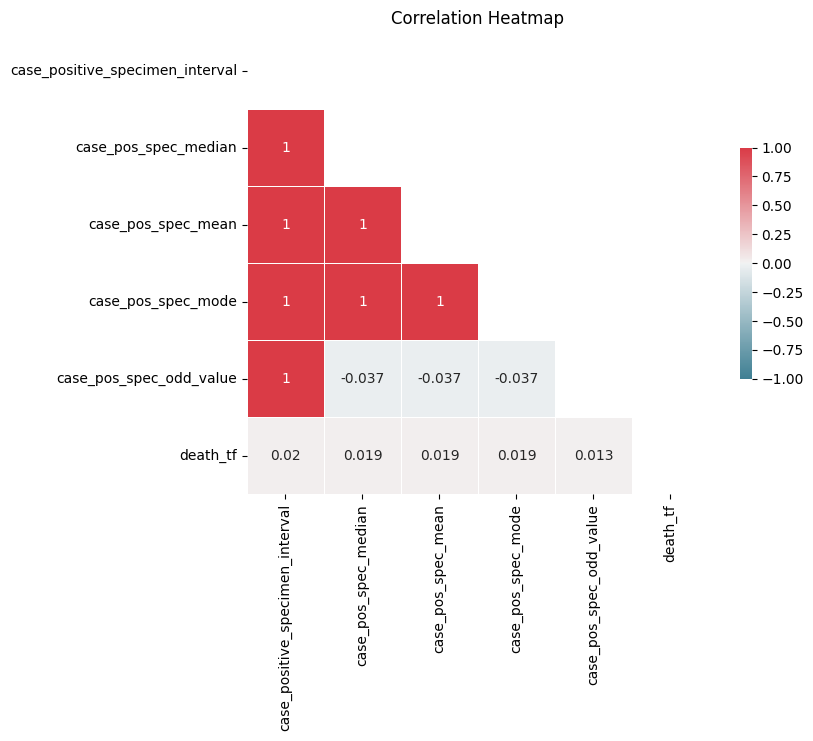

In [110]:
plot_correlation_heatmap(data_case_pos_spec_na, ['case_positive_specimen_interval', 'case_pos_spec_median', 'case_pos_spec_mean', 'case_pos_spec_mode', 'case_pos_spec_odd_value', 'death_tf'])

Reviewing the correlations above, it is evident that the differences in the correlations with the target feature are minimal. The variations observed between the original column with null values and the columns where imputation was performed are very slight, with none of the differences exceeding 0.007. 

|Replacement Column|correlation with death_tf|difference in correlation|
|:----|:----|:----|
|case_positive_specimen_interval|0.02|-|
|case_pos_spec_median|0.019|0.001|
|case_pos_spec_mean|0.019|0.001|
|case_pos_spec_mode|0.019|0.001|
|case_pos_spec_odd_value|0.013|0.007|

We conclude that the imputation process had a negligible impact on the correlations between the features and the target variable. We will choose the option that is closest to the original and drop the original column. In this case mean, median, and mode all present with the same correlation and we will arbitrarily choose to use the mode.

In [111]:
data_cleaned = data.copy()
data_cleaned['case_positive_specimen_interval'] = data_case_pos_spec_na['case_pos_spec_mode']

#### Case Onset Interval
We will perform the same steps for the 'case_onset_interval' feature.

In [112]:
# Address null values for case_positive_specimen_interval
data_case_onset_na= data.copy()

# Option 1.1: Impute with median
data_case_onset_na['case_onset_median'] = data['case_onset_interval'].fillna(data['case_onset_interval'].median()).astype('Int64')
# Option 1.2: Impute with mean
data_case_onset_na['case_onset_mean'] = data['case_onset_interval'].fillna(data['case_onset_interval'].mean().round()).astype('Int64')
# Option 1.1: Impute with mode
data_case_onset_na['case_onset_mode'] = data['case_onset_interval'].fillna(data['case_onset_interval'].mode().values[0]).astype('Int64')

# Option 2: Impute with strange value 999
data_case_onset_na['case_onset_odd_value'] = data['case_onset_interval'].fillna(999).astype('Int64')

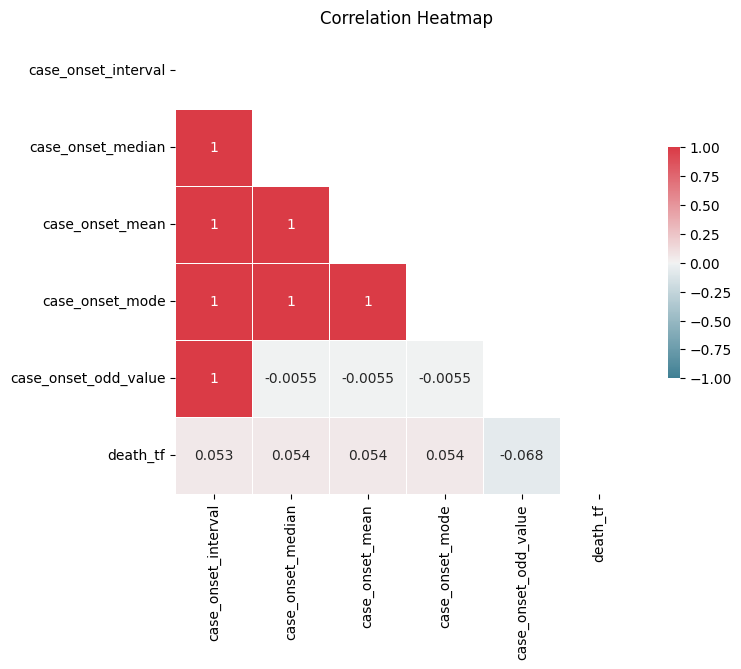

In [113]:
plot_correlation_heatmap(data_case_onset_na, ['case_onset_interval', 'case_onset_median', 'case_onset_mean', 'case_onset_mode', 'case_onset_odd_value', 'death_tf'])

Once again, the differences in the correlations with the target feature are minimal. With the exception of the case_onset_odd_value, none of the differences exceeds 0.001. 

|Replacement Column|correlation with death_tf|difference in correlation|
|:----|:----|:----|
|case_onset_interval|0.053|-|
|case_onset_median|0.054|-0.001|
|case_onset_mean|0.054|-0.001|
|case_onset_mode|0.054|-0.001|
|case_onset_odd_value|-0.068|0.121|

We conclude that the imputation process had a negligible impact on the correlations between the features and the target variable. Again mean, median, and mode are equally correlated with the target feature, and we choose to use the mode for consistency. We can now drop the original column.

In [114]:
data_cleaned['case_onset_interval'] = data_case_onset_na['case_onset_mode']

After making these changes, we can verify that null values are no longer present in the set and proceed to splitting the data for training and testing.

In [115]:
data_cleaned.isna().sum()

case_month                         0
state_fips_code                    0
age_group                          0
sex                                0
race                               0
ethnicity                          0
case_positive_specimen_interval    0
case_onset_interval                0
laboratory_confirmed_tf            0
symptomatic_tf                     0
hosp_tf                            0
death_tf                           0
income                             0
people_vaccinated                  0
risk_factor_tf                     0
dtype: int64

## 2.2 Splitting the data into two data sets

We can now split the data into two datasets. We have elected not to shuffle the data set because sklearn's split function will shuffle it before splitting. **70%** of the data will be used for training and **30%** will be use for testing.

We will set the random_state variable to 0, to allow the random shuffle to be repeated within this notebook.

In [116]:
from sklearn.model_selection import train_test_split

# Load the dataset into a pandas dataframe and set X and y
X = data_cleaned[['case_month', 'state_fips_code', 'age_group', 'sex', 'race', 'ethnicity', 'case_positive_specimen_interval', 'case_onset_interval', 'laboratory_confirmed_tf', 'symptomatic_tf', 'hosp_tf', 'income', 'people_vaccinated', 'risk_factor_tf' ]]
y = data_cleaned['death_tf']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Concatenate the X and y training variables into a table.
data_training = pd.concat([X_train, y_train], axis=1)

# Concatenate the X and y testing variables into a table.
data_testing = pd.concat([X_test, y_test], axis=1)

To be as transparent as possible when we split the data, we print the range of rows in the original table, the training table, and the testing table.

In [117]:
print("original range is:\t rows 0 to", data_cleaned.shape[0])
print("training range (70%):\t rows 0 to", round(data_training.shape[0]))
print("test range (30%): \t rows", round(data_training.shape[0]), "to", round(data_training.shape[0]) + data_testing.shape[0])

original range is:	 rows 0 to 37940
training range (70%):	 rows 0 to 26558
test range (30%): 	 rows 26558 to 37940


## 2.3 Start working with the training set

To get a better understanding of the data we are working with, we will analyze the features in our dataset. We will achieve this by analyzing relationships between both continuous and categorical features, both among themselves and with the target feature.

***
### 2.3.1 Continuous Features
***
#### **2.3.1.1 Continuous - Continuous Plots**

<span style="color:red;"> We first get the correlation between continuous features </span>

In [121]:
# Add the target feature to the list of continuous columns
continuous_corr_features = continuous + ['death_tf']

# Print the correlation between the continuous data types
get_correlations(data_training, continuous_corr_features, abs_corr=True)

,case_month,case_positive_specimen_interval,case_onset_interval,income,people_vaccinated,death_tf
case_month,1.000000,0.036916,0.041621,0.024631,0.941525,0.290332
case_positive_specimen_interval,0.036916,1.000000,0.001640,0.028783,0.031806,0.018429
case_onset_interval,0.041621,0.001640,1.000000,0.021305,0.047823,0.058749
income,0.024631,0.028783,0.021305,1.000000,0.018851,0.040278
people_vaccinated,0.941525,0.031806,0.047823,0.018851,1.000000,0.262234
death_tf,0.290332,0.018429,0.058749,0.040278,0.262234,1.000000


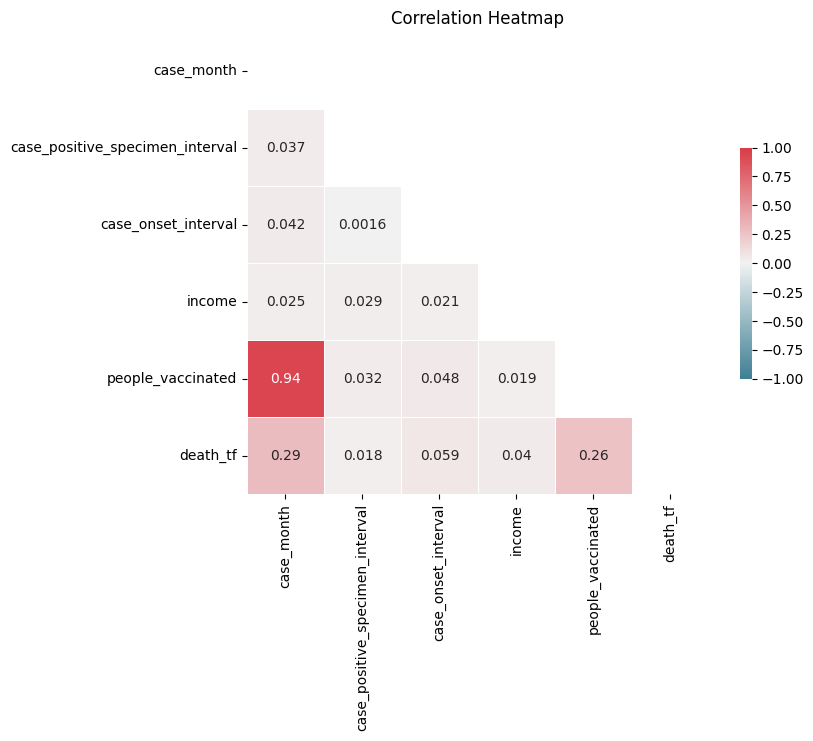

In [119]:
# Print the correlation table
plot_correlation_heatmap(data_training, continuous_corr_features, abs_corr=True)

##### Interpretation of the results
- **Strong Correlations** - Of our few continuous features, there are two with a strong correlations. 'people_vaccinated' and 'case_month' have a correlation of 0.94. This is to be expected, since as time passes, more and more people are vaccinated. We can choose to drop one of these features, since they will trend in a similar direction, but as vaccination rates plateau and case months continue to grow, it may be beneficial to keep the two parameters separate. Keeping them distinct allows us to capture the temporal aspect and understand the evolving relationship between vaccinations and cases.  
$~$
- **Weak Correlations** - The remaining features all have weak correlation. This is to be expected, since it indicates that these features operate independently and do not have a significant impact on each other. Despite their weaker associations, these features still provide unique information that can contribute to the predictive models, offering valuable insights into other factors impacting the target variable.

#### **2.3.1.2 Continuous - Target Feature Plots**
We will create scatter plots to compare each continuous feature with the target feature. This visual analysis will help us identify the features that have a stronger potential to predict the target variable and distinguish them from the less relevant features. By examining these scatter plots, we can isolate a subset of features that appear to be more indicative, allowing us to focus our modeling efforts on the most relevant variables. Features with weaker associations can be eliminated to streamline the model and reduce noise.

,RiskPerformance
case_month,0.290332
people_vaccinated,0.262234
case_onset_interval,0.058749
income,0.040278
case_positive_specimen_interval,0.018429


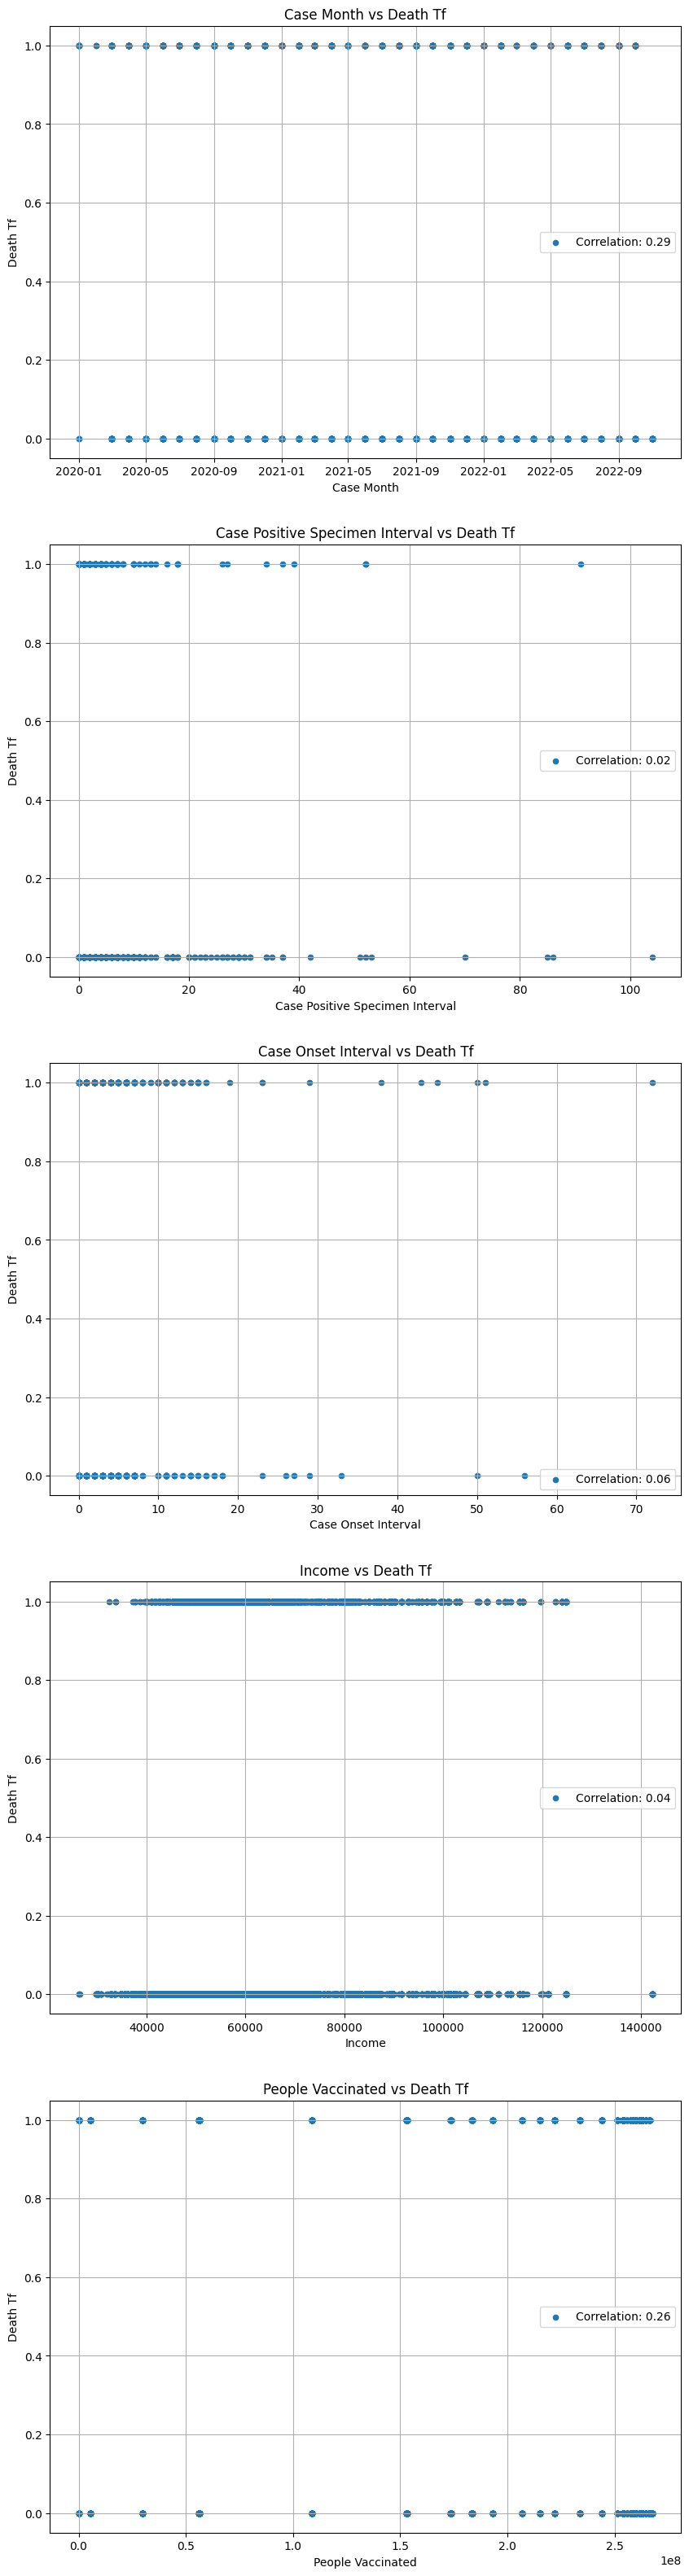

In [124]:
n = len(continuous_corr_features)
fig, axs = plt.subplots(ncols=1, nrows=n-1, figsize=(10,40))

# dict to hold correlation values 
corr_dict = {}

target_feature = 'death_tf'

for i, feature in enumerate(continuous_corr_features):
    if feature != target_feature:
        xlabel = feature.replace("_", " ").title()
        ylabel = target_feature.replace("_", " ").title()

        correlation = data_training[[feature, target_feature]].corr(numeric_only=False).values[0,1]
        title = xlabel + " vs " + ylabel
        values = data_training[[feature, target_feature]]
        scatter = values.plot.scatter(x=feature, y=target_feature, ax=axs[i], grid=True, fontsize=10)
        scatter.legend(["Correlation: {:.2f}".format(abs(correlation))])
        scatter.set_xlabel(xlabel)
        scatter.set_ylabel(ylabel)
        scatter.set_title(title)

        # add correlation to dict
        corr_dict[feature] = abs(correlation)

# dataframe holding sorted correlation values to aid in interpreting results
corr_df = pd.DataFrame.from_dict(corr_dict, orient='index', columns=['RiskPerformance']).sort_values('RiskPerformance', ascending=False)
corr_df

##### Interpretation of the results
- After analyzing the plots, it is evident that there is no single feature that exhibits a very strong correlation with the target feature. This aligns with our understanding of the complexity of predicting survival from COVID-19. The outcome is influenced by a multitude of factors, and no single feature can serve as a definitive indicator of survival.

- We categorized the correlation values into three bins: low correlation, medium correlation, and high correlation. The boundaries for each bin are arbitrary and used solely for classification purposes.


| Low correlation | Medium correlation | High correlation |
|-----------------|--------------------|------------------|
| x <= 0.02       | 0.02 < x < 0.10    | x >= 0.10       |
| 3 features    | 0  features        | 2 features       |
| 60%             | 0%                | 20%              | 

- The strongest correlations are observed between 'case_month'/'people_vaccinated' and 'death_tf'. This correlation is expected as both features are closely related to the progression of time and the impact of vaccinations. The strong correlations of these features with 'death_tf' align with our expectations, as the duration of the pandemic is likely to capture the complex factors contributing to the severity of the virus.
- Although three features demonstrate low correlations, we have decided to retain them in the dataset for the time being. Removing these features would result in the elimination of a significant portion of the dataset. The impact of this decision will be evaluated in Part 5, where we assess the overall performance of the model.

#### **Continuous - Target Plots**
<li style="color: blue; font-style: italic">For each continuous feature, plot its interaction with the target feature (a plot for each pair of continuous feature and target feature). Discuss what you observe from these plots, e.g., which continuous features seem to be better at predicting the target feature? </li>


AttributeError: 'numpy.int64' object has no attribute 'replace'

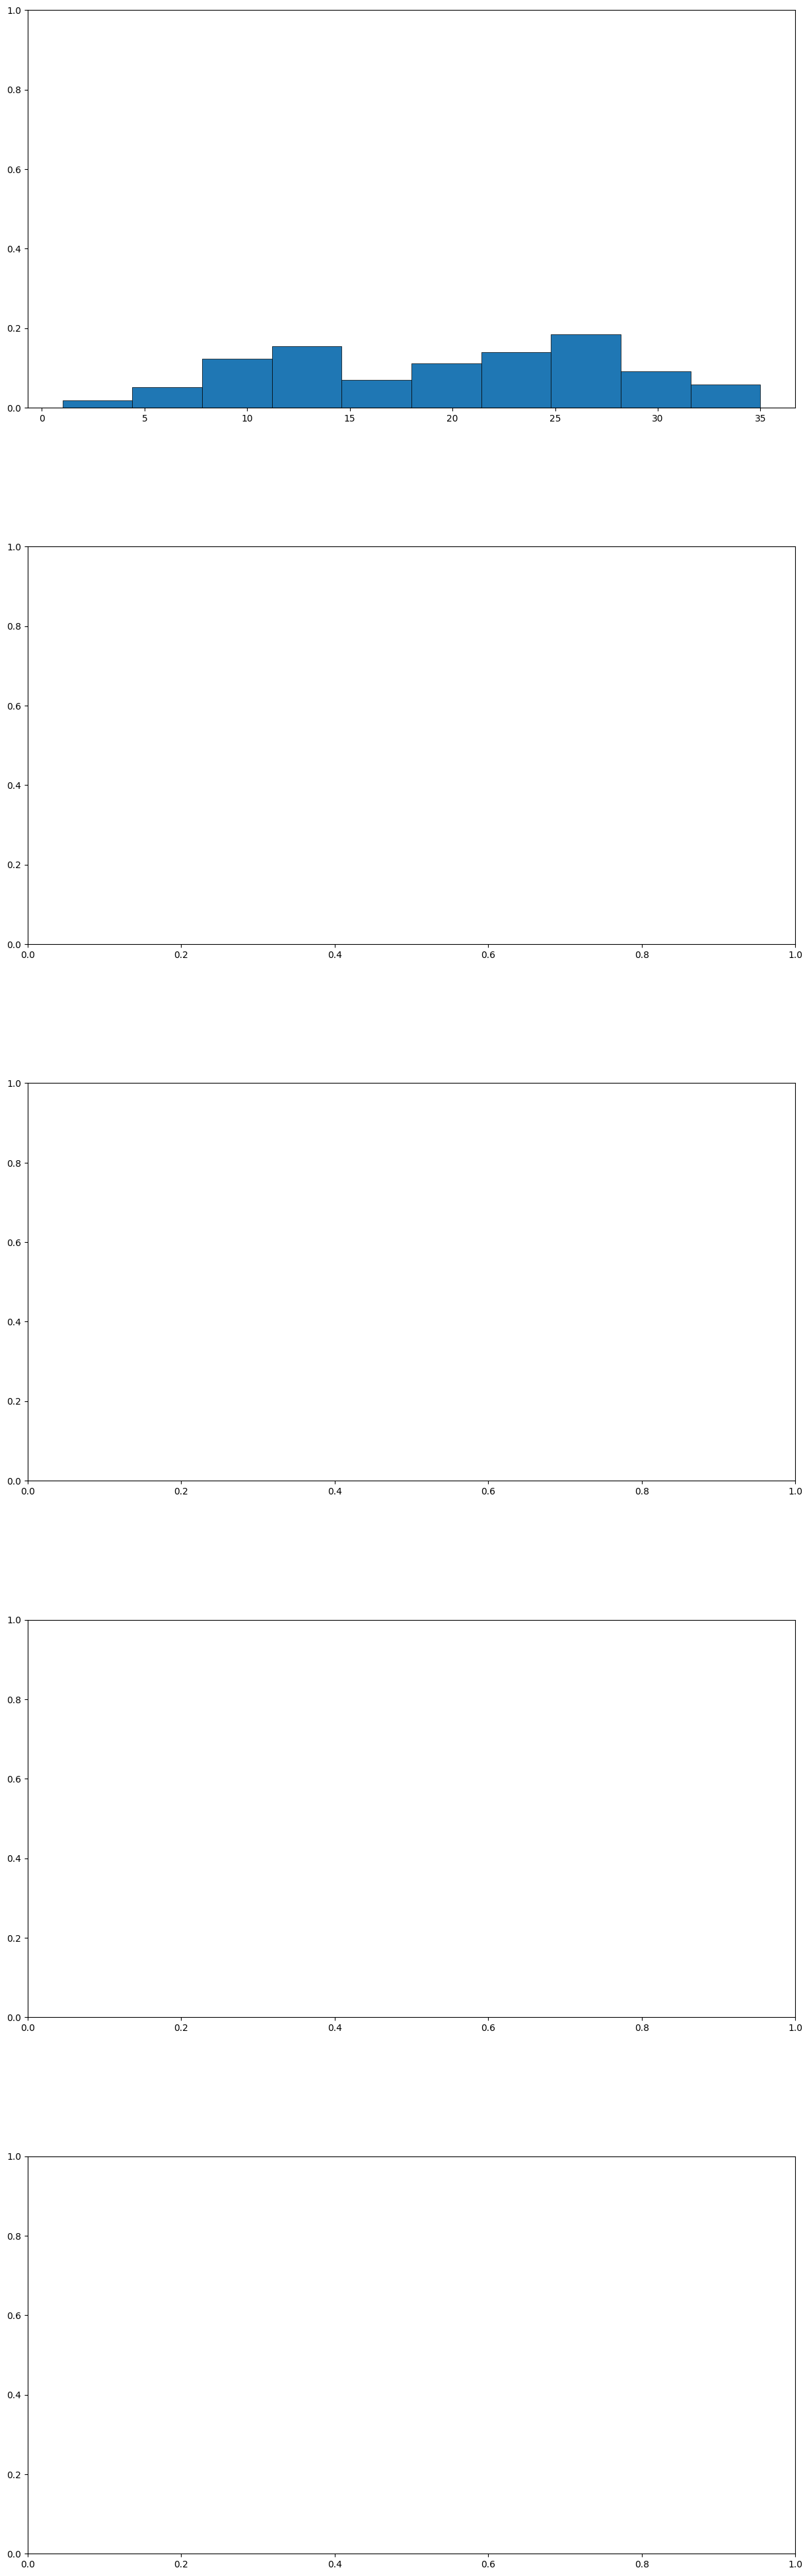

In [125]:
fig, axs = plt.subplots(ncols=1, nrows=5, figsize=(15,50))
fig.subplots_adjust(hspace=0.35)

for i, column in enumerate(continuous):
    if column == 'case_positive_specimen_interval' or column == 'case_onset_interval':
        createStackedHistograms(data_training, 'death_tf', column, bin_count = 14, ax=axs[i], filterExp=lambda row: row[column] <= 14, ylim=2)
    else:
        createStackedHistograms(data_training, 'death_tf', column, bin_count = 10, ax=axs[i])

#### **Selection of Indicative Continuous Features**
The set of indicative continuous features we will be using includes the following:
* case_positive_specimen_interval
* income
* case_month

The selection is based on both the information revealed in the frequency histograms and the correlation statistics from above. We have elected to eliminate the 'case_onset_interval' columns because of the overwhelming majority of values that result in 0 for this columns, and the even distribution of deaths (Yes and No within 1% of each other) for each value of this attribute. On the other hand, we have elected to keep 'case_positive_specimen_interval', since even though the overwhelming majority of values is 0, there is a correlation between deaths and the value. When the 'case_positive_specimen_interval' value is 0, the amount of deaths vs survivors is 70% vs 88%. For the next 4 values, these percentages flip, and the amount of deaths vs survivors is 12% vs 7%, 9% vs 1%, and 8% vs 1%.  
Income is another value we will keep (at least for now) because although there does seem to be a slight correlation between this number and death, and there is a nice distribution of data that may start to lead some interesting results.
Lastly, we will include case_month since there are clear trends between this value and the amount of deaths: i.e. earlier on there were more deaths, and later on there were less deaths. We have chosen to keep this column and eliminate the people_vaccinated column because there is a large correlation (94%) between the 2 columns, and case_month can capture other factors, like seasonal changes in the impact of the virus, the contagiousness of the virus, as well as the deadliness of the prevalent variant of the virus.

***
### Categorical Features
***

#### **Categorical - Categorical Plots**
<li style="color: blue; font-style: italic">Plot the correlations between all the categorical features (if any). Discuss what you observe in these plots.  </li>

#### **Categorical - Target Plots**
<li style="color: blue; font-style: italic">For each categorical feature, plot its pairwise interaction with the target feature. Discuss what  knowledge you gain from these plots, e.g., which categorical features seem to be better at predicting the target feature? </li>

#### **Selection of Indicative Categorical Features**
 <li style="color: blue; font-style: italic"> Choose a subset of categorical features you find promising (if any). Justify your choices. </li>

# **3.0 Predictive Modeling: Linear Regression** 

## 3.1 Train the Linear Regression Model
<span style="color: blue; font-style:italic;">On the training set, train a linear regression model to predict the target feature, using only the  descriptive features selected in exercise (1) above. </span>

## 3.2 Interpret the Linear Regression Model

### **Coefficients**
<span style="color: blue; font-style: italic;">  Print the coefficients learned by the model and discuss their role in the model (e.g., interpret the model by analysing each coefficient and how it relates each input feature to the target feature).  </span>

### **Target Feature Values and Predicted Class**
<span style="color: blue; font-style: italic;">  Print the predicted target feature value for the first 10 training examples. Threshold the predicted target feature value given by the linear regression model at 0.5, to get the predicted class for each example. Print the predicted class for the first 10 examples.</span>

### **Classification Evaluation Measures on Training Set**
<span style="color: blue; font-style: italic;">   Print a few classification evaluation measures computed on the full training set (e.g., Accuracy, Confusion matrix, Precision, Recall, F1)</span>

### **Running Analysis**
<span style="color: blue; font-style: italic"> discuss your findings so far. </span>

## 3.3 Evaluate the Linear Regression Model

### **Classification Evaluation Measures on the Testing Set**
<span style="color: blue; font-style: italic"> Evaluate the model using classification evaluation measures on the hold-out (30% examples) test set. Compare these results with the evaluation results obtained on the training (70%) dataset. </span>

### **Classification Evaluation Measures on Cross-Validated Set**
<span style="color: blue; font-style: italic"> Also compare these results with a cross-validated model (i.e., a new model trained and evaluated using cross-validation on the full dataset). You can use classic k-fold cross-validation or repeated random train/test (70/30) splits. </span>

### **Running Analysis**
<span style="color: blue; font-style: italic"> Compare the cross-validation metrics to those obtained on the single train/test split and discuss your findings. </span>

# **4.0 Predictive Modeling: Logistic Regression** 

## 4.1 Train the Logistic Regression Model
<span style="color: blue; font-style:italic;">On the training set, train a logistic regression model to predict the target feature, using only the  descriptive features selected in exercise (1) above. </span>

## 4.2 Interpret the Logistic Regression Model

### **Coefficients**
<span style="color: blue; font-style: italic;">  Print the coefficients learned by the model and discuss their role in the model (e.g., interpret the model by analysing each coefficient and how it relates each input feature to the target feature).  </span>

### **Target Feature Values and Predicted Class**
<span style="color: blue; font-style: italic;">  Print the predicted target feature value for the first 10 training examples. Threshold the predicted target feature value given by the linear regression model at 0.5, to get the predicted class for each example. Print the predicted class for the first 10 examples.</span>

### **Classification Evaluation Measures on Training Set**
<span style="color: blue; font-style: italic;">   Print a few classification evaluation measures computed on the full training set (e.g., Accuracy, Confusion matrix, Precision, Recall, F1)</span>

### **Running Analysis**
<span style="color: blue; font-style: italic"> discuss your findings so far. </span>

## 4.3 Evaluate the Logistic Regression Model

### **Classification Evaluation Measures on the Testing Set**
<span style="color: blue; font-style: italic"> Evaluate the model using classification evaluation measures on the hold-out (30% examples) test set. Compare these results with the evaluation results obtained on the training (70%) dataset. </span>

### **Classification Evaluation Measures on Cross-Validated Set**
<span style="color: blue; font-style: italic"> Also compare these results with a cross-validated model (i.e., a new model trained and evaluated using cross-validation on the full dataset). You can use classic k-fold cross-validation or repeated random train/test (70/30) splits. </span>

### **Running Analysis**
<span style="color: blue; font-style: italic"> Compare the cross-validation metrics to those obtained on the single train/test split and discuss your findings. </span>

# **5.0 Predictive Modeling: Random Forest** 

## 5.1 Train the Random Forest Model
<span style="color: blue; font-style:italic;">On the training set, train a random forest model to predict the target feature, using only the  descriptive features selected in exercise (1) above. </span>

## 5.2 Interpret the Random Forest Model

### **Coefficients**
<span style="color: blue; font-style: italic;">  Can you interpret the random forest model? Discuss any knowledge you can gain in regard of the working of this model.     </span>

### **Target Feature Values and Predicted Class**
<span style="color: blue; font-style: italic;">  Print the predicted target feature value for the first 10 training examples. Print the predicted class for the first 10 examples.</span>

### **Classification Evaluation Measures on Training Set**
<span style="color: blue; font-style: italic;">   Print a few classification evaluation measures computed on the full training set (e.g., Accuracy, Confusion matrix, Precision, Recall, F1)</span>

### **Running Analysis**
<span style="color: blue; font-style: italic"> discuss your findings so far. </span>

## 5.3 Evaluate the Random Forest Model

### **Classification Evaluation Measures on the Testing Set**
<span style="color: blue; font-style: italic"> Evaluate the model using classification evaluation measures on the hold-out (30% examples) test set. Compare these results with the evaluation results obtained on the training (70%) dataset. </span>

### **Classification Evaluation Measures on Cross-Validated Set**
<span style="color: blue; font-style: italic"> Also compare these results with a cross-validated model (i.e., a new model trained and evaluated using cross-validation on the full dataset). You can use classic k-fold cross-validation or repeated random train/test (70/30) splits. </span>

### **Running Analysis**
<span style="color: blue; font-style: italic"> Compare the cross-validation metrics to those obtained on the single train/test split and to the Random Forest out-of-sample error and discuss your findings. </span>

# **6.0 Conclusions**

<ul style="color:blue; font-style: italic;">
<li> Which model of the ones trained above performs better at predicting the target feature? Is it more accurate than a simple model that always predicts the majority class (i.e., if 'no' is the majority class in your dataset, the simple model always predicts 'no' for the target feature)? Justify your answers. </li>
<li> Summarise your understanding of the problem and of your predictive modeling results so far. Can you think of any new ideas to improve the best model so far (e.g., by using further data prep such as: feature selection, feature re-scaling, creating new features, combining predictive models, or using other domain knowledge)? Please show how your ideas actually work in practice (with code), by training and evaluating your proposed models. Summarise your findings so far. </li></ul>